In [ ]:
#install the pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=281703690fbb9b83e6c3852b6c1c2f6ce6d8de25e807009ccb9374b23e8d3874
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# create pyspark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read dataset
dataset = spark.read.csv('/content/diabetes.csv',inferSchema=True, header =True)

In [ ]:
#display the columns in the dataset
dataset.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [ ]:
#describing the dataset
dataset.describe().select("Summary","Pregnancies","Glucose","BloodPressure").show()

+-------+------------------+-----------------+------------------+
|Summary|       Pregnancies|          Glucose|     BloodPressure|
+-------+------------------+-----------------+------------------+
|  count|               768|              768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|
|    min|                 0|                0|                 0|
|    max|                17|              199|               122|
+-------+------------------+-----------------+------------------+



In [ ]:
dataset.describe().select("Summary","SkinThickness","Insulin").show()

+-------+------------------+------------------+
|Summary|     SkinThickness|           Insulin|
+-------+------------------+------------------+
|  count|               768|               768|
|   mean|20.536458333333332| 79.79947916666667|
| stddev|15.952217567727642|115.24400235133803|
|    min|                 0|                 0|
|    max|                99|               846|
+-------+------------------+------------------+



In [ ]:
dataset.describe().select("Summary","BMI","DiabetesPedigreeFunction","Age").show()

+-------+------------------+------------------------+------------------+
|Summary|               BMI|DiabetesPedigreeFunction|               Age|
+-------+------------------+------------------------+------------------+
|  count|               768|                     768|               768|
|   mean|31.992578124999977|      0.4718763020833327|33.240885416666664|
| stddev| 7.884160320375441|       0.331328595012775|11.760231540678689|
|    min|               0.0|                   0.078|                21|
|    max|              67.1|                    2.42|                81|
+-------+------------------+------------------------+------------------+



In [ ]:
# replace min value of zeros with Nan as data cleaning processs
import numpy as np
from pyspark.sql.functions import when
dataset=dataset.withColumn("Glucose",when(dataset.Glucose==0,np.nan).otherwise (dataset.Glucose))
dataset=dataset.withColumn("BloodPressure",when(dataset.BloodPressure==0,np.nan).otherwise(dataset.BloodPressure))
dataset=dataset.withColumn("SkinThickness",when(dataset.SkinThickness==0,np.nan).otherwise(dataset.SkinThickness))
dataset=dataset.withColumn("BMI",when(dataset.BMI==0,np.nan).otherwise(dataset.BMI))
dataset=dataset.withColumn("Insulin",when(dataset.Insulin==0,np.nan).otherwise(dataset.Insulin))
dataset.select("Insulin","Glucose","BloodPressure","SkinThickness","BMI").show(10)

+-------+-------+-------------+-------------+----+
|Insulin|Glucose|BloodPressure|SkinThickness| BMI|
+-------+-------+-------------+-------------+----+
|    NaN|  148.0|         72.0|         35.0|33.6|
|    NaN|   85.0|         66.0|         29.0|26.6|
|    NaN|  183.0|         64.0|          NaN|23.3|
|   94.0|   89.0|         66.0|         23.0|28.1|
|  168.0|  137.0|         40.0|         35.0|43.1|
|    NaN|  116.0|         74.0|          NaN|25.6|
|   88.0|   78.0|         50.0|         32.0|31.0|
|    NaN|  115.0|          NaN|          NaN|35.3|
|  543.0|  197.0|         70.0|         45.0|30.5|
|    NaN|  125.0|         96.0|          NaN| NaN|
+-------+-------+-------------+-------------+----+
only showing top 10 rows



In [ ]:
#impute(removing NaN values)
from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"],outputCols=["Glucose","BloodPressure","SkinThickness","BMI","Insulin"])
model=imputer.fit(dataset)
dataset=model.transform(dataset)
dataset.show(5)

+-----------+-------+-------------+------------------+-----------------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|     SkinThickness|          Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+------------------+-----------------+----+------------------------+---+-------+
|          6|  148.0|         72.0|              35.0|155.5482233502538|33.6|                   0.627| 50|      1|
|          1|   85.0|         66.0|              29.0|155.5482233502538|26.6|                   0.351| 31|      0|
|          8|  183.0|         64.0|29.153419593345657|155.5482233502538|23.3|                   0.672| 32|      1|
|          1|   89.0|         66.0|              23.0|             94.0|28.1|                   0.167| 21|      0|
|          0|  137.0|         40.0|              35.0|            168.0|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+------------------+-----------------+----+---

In [ ]:
#us combine all the features in one single feature vector.
cols=dataset.columns
cols.remove("Outcome")

# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")

# Now let us use the transform method to transform our dataset
dataset=assembler.transform(dataset)
dataset.select("features").show(truncate=False)

+-----------------------------------------------------------------------------------+
|features                                                                           |
+-----------------------------------------------------------------------------------+
|[6.0,148.0,72.0,35.0,155.5482233502538,33.6,0.627,50.0]                            |
|[1.0,85.0,66.0,29.0,155.5482233502538,26.6,0.351,31.0]                             |
|[8.0,183.0,64.0,29.153419593345657,155.5482233502538,23.3,0.672,32.0]              |
|[1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0]                                          |
|[0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0]                                        |
|[5.0,116.0,74.0,29.153419593345657,155.5482233502538,25.6,0.201,30.0]              |
|[3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0]                                          |
|[10.0,115.0,72.40518417462484,29.153419593345657,155.5482233502538,35.3,0.134,29.0]|
|[2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0]          

In [ ]:
#Standard Sclarizer (scaling the values like eg range 1 to 10 to 0.1 and 11 to 20 as 0.2 etcfor eg)
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
dataset=standardscaler.fit(dataset).transform(dataset)
dataset.select("features","Scaled_features").show(20)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[6.0,148.0,72.0,3...|[1.78063837321943...|
|[1.0,85.0,66.0,29...|[0.29677306220323...|
|[8.0,183.0,64.0,2...|[2.37418449762590...|
|[1.0,89.0,66.0,23...|[0.29677306220323...|
|[0.0,137.0,40.0,3...|[0.0,4.5012560836...|
|[5.0,116.0,74.0,2...|[1.48386531101619...|
|[3.0,78.0,50.0,32...|[0.89031918660971...|
|[10.0,115.0,72.40...|[2.96773062203238...|
|[2.0,197.0,70.0,4...|[0.59354612440647...|
|[8.0,125.0,96.0,2...|[2.37418449762590...|
|[4.0,110.0,92.0,2...|[1.18709224881295...|
|[10.0,168.0,74.0,...|[2.96773062203238...|
|[10.0,139.0,80.0,...|[2.96773062203238...|
|[1.0,189.0,60.0,2...|[0.29677306220323...|
|[5.0,166.0,72.0,1...|[1.48386531101619...|
|[7.0,100.0,72.405...|[2.07741143542266...|
|[0.0,118.0,84.0,4...|[0.0,3.8769942910...|
|[7.0,107.0,74.0,2...|[2.07741143542266...|
|[1.0,103.0,30.0,3...|[0.29677306220323...|
|[1.0,115.0,70.0,3...|[0.2967730

In [ ]:
#Train, test split
train, test = dataset.randomSplit([0.8, 0.2], seed=12345)

In [ ]:
 #imbalance in the dataset
dataset_size=float(train.select("Outcome").count())
numPositives=train.select("Outcome").where('Outcome == 1').count()
print('The number of ones are {}'.format(numPositives))

The number of ones are 221


In [ ]:
#finding the number of negatives
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('Percentage of ones are {}'.format(per_ones))
print('The number of numNegatives {}'.format(numNegatives))

Percentage of ones are 35.24720893141946
The number of numNegatives 406.0


In [ ]:
#balancing the ratio
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.6475279106858054


In [ ]:
# balance by adding the class weights
train=train.withColumn("classWeights", when(train.Outcome == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+------------------+
|      classWeights|
+------------------+
|0.3524720893141946|
|0.3524720893141946|
|0.3524720893141946|
|0.3524720893141946|
|0.3524720893141946|
+------------------+
only showing top 5 rows



In [ ]:
#Feature selection (fpr = false positive rate)
# Feature selection using chisquareSelector
from pyspark.ml.feature import ChiSqSelector
css = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect',labelCol='Outcome',fpr=0.05)
train=css.fit(train).transform(train)
test=css.fit(test).transform(test)
test.select("Aspect").show(5,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------+
|Aspect                                                                                                                                  |
+----------------------------------------------------------------------------------------------------------------------------------------+
|[0.0,2.7598942410664704,6.778906518747398,3.526357045954172,1.4702231396384098,5.556241336417194,0.7032293726142661,1.955743806611537]  |
|[0.0,3.3184442660442084,5.290853868290652,1.93380870262003,1.8295247783934943,3.0544782215906037,0.7605742570763735,1.785679127775751]  |
|[0.0,3.3184442660442084,5.373523459982693,3.1850966866682846,1.8295247783934943,3.5781030595775647,0.7153019798694465,1.870711467193644]|
|[0.0,3.3513001498664283,6.2002193769031075,2.616329421191805,1.8295247783934943,4.720981710256498,1.726382837490816,1.785679127775751]  |
|[0.0,3.449867801333088,5.6

In [ ]:
#Building a classification model using Logistic Regression (LR)
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Outcome", featuresCol="Aspect",weightCol="classWeights",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("Outcome","prediction").show(10)

+-------+----------+
|Outcome|prediction|
+-------+----------+
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      0|       0.0|
|      1|       1.0|
|      1|       1.0|
+-------+----------+
only showing top 10 rows



In [ ]:
#Evaluating the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="Outcome")
predict_test.select("Outcome","rawPrediction","prediction","probability").show(5)

+-------+--------------------+----------+--------------------+
|Outcome|       rawPrediction|prediction|         probability|
+-------+--------------------+----------+--------------------+
|      0|[1.92703060509029...|       0.0|[0.87292038835456...|
|      0|[2.86679587735939...|       0.0|[0.94618041741076...|
|      0|[2.56925761588805...|       0.0|[0.92885665332668...|
|      0|[1.51041800877943...|       0.0|[0.81912314746457...|
|      0|[2.86307413613929...|       0.0|[0.94599058003314...|
+-------+--------------------+----------+--------------------+
only showing top 5 rows



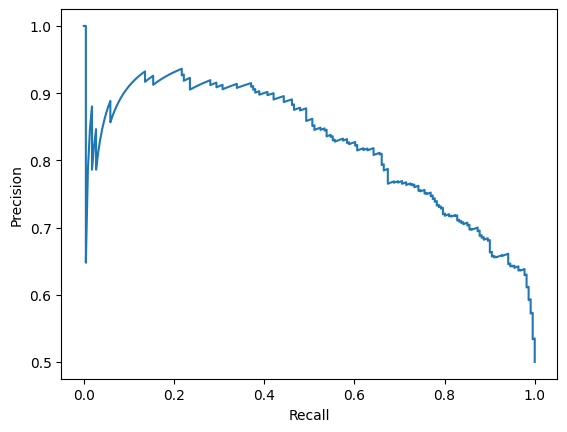

In [ ]:
print(model.summary)
import matplotlib.pyplot as plt
pr = model.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()